## European Call Option with Stochastic Volatility

### Risk-Neutral Dynamics:

Underlying process:
$\large dS_{t} = r S_{t} dt + \sqrt{v_{t}} S_{t} dW^\mathbb{Q}_{s,t}$

Variance process:
$\large dv_{t} = \kappa (\theta - v_{t})dt + \sigma \sqrt{v_{t}} dW^\mathbb{Q}_{v,t}$

- $dW^\mathbb{Q}_{S,t}$ Brownian motion of asset price \
- $dW^\mathbb{Q}_{v,t}$ Brownian motion of asset's price variance \
- $\rho^\mathbb{Q}$ correlation between $dW^\mathbb{Q}_{S,t}$ and $dW^\mathbb{Q}_{v,t}$

### Breeden-Litzenberger Formula

Let's determine the risk-neutral probability distribution function (pdf), $f _\mathbb{Q}$.

$\large f _\mathbb{Q}(K, \tau) = e^{r \tau} \frac{\partial^2C(K,\tau)}{\partial K^2}$

Using a second-order finite difference approximation:

$\large f_\mathbb{Q}(K, \tau) \approx e^{r\tau} \frac{C(K+\Delta_K,\tau) - 2C(K,\tau) + C(K-\Delta_K,\tau)}{(\Delta_K)^2}$

---

### Heston Model Characteristic Equation:

$\large C(S_0, K, v_0, \tau) = \frac{1}{2}(S_0 - K e^{-r \tau}) + \frac{1}{\pi} \int^\infty_0 \Re \left[ e^{r\tau} \frac{\varphi(\phi-i)}{i\phi K^{i\phi}} - K\frac{\varphi(\phi)}{i\phi K^{i\phi}} \right] d\phi$

$\varphi(X_0, K, v_0,\tau, \phi) = e^{r \phi i \tau} S^{i \phi} \left[\frac{1 - g e^{d\tau}}{1 - g}\right]^{\frac{-2a}{\sigma^2}} 
\exp\left[\frac{a \tau}{\sigma^2} (b_2 - \rho\sigma \phi i + d) + \frac{v_0}{\sigma^2} (b_2 - \rho\sigma \phi i + d) \left(\frac{1 - e^{d\tau}}{1 - g e^{d\tau}} \right) \right]$

where:

$d = \sqrt{(\rho\sigma \phi i - b)^2 + \sigma^2 (\phi i + \phi^2)}$

$g = \frac{b - \rho\sigma \phi i + d}{b - \rho\sigma \phi i - d}$

$a = \kappa \theta, \quad b = \kappa + \lambda$

References:
- [Heston Model PDF](https://www.maths.univ-evry.fr/pages_perso/crepey/Finance/051111_mikh%20heston.pdf)
- [Gatheral Notes](http://web.math.ku.dk/~rolf/teaching/ctff03/Gatheral.1.pdf)

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import savgol_filter
from datetime import datetime

/Users/rahulgupta/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


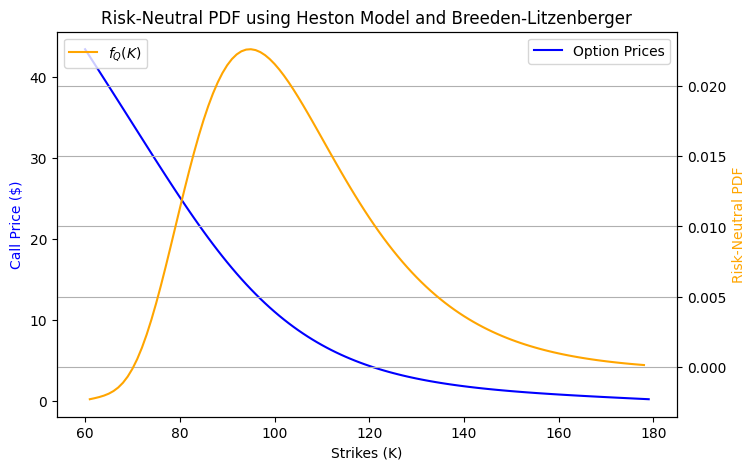

In [1]:
# -------------------------------------------------
# Heston Model Parameters
# -------------------------------------------------
S0 = 100.0     # Initial stock price
tau = 1.0      # Time to maturity (years)
r = 0.06       # Annual risk-free rate

# Heston-dependent parameters
kappa = 3              # Rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # Long-term mean of variance under risk-neutral dynamics
v0 = 0.20**2           # Initial variance under risk-neutral dynamics
rho = 0.98            # Correlation between returns and variances
sigma = 0.2           # Volatility of volatility
lambd = 0             # Risk premium of variance

# Ensure the Feller Condition is satisfied
assert 2*kappa*theta > sigma**2, "Feller condition violated!"

# -------------------------------------------------
# Characteristic Function for Heston Model
# -------------------------------------------------
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
    Compute the characteristic function of the Heston model.
    """
    a = kappa * theta
    b = kappa + lambd
    rspi = rho * sigma * phi * 1j
    d = np.sqrt((rspi - b) ** 2 + (phi * 1j + phi ** 2) * sigma ** 2)
    g = (b - rspi + d) / (b - rspi - d)

    exp1 = np.exp(r * phi * 1j * tau)
    term2 = S0 ** (phi * 1j) * ((1 - g * np.exp(d * tau)) / (1 - g)) ** (-2 * a / sigma ** 2)
    exp2 = np.exp(a * tau * (b - rspi + d) / sigma ** 2 + v0 * (b - rspi + d) * 
                 ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau))) / sigma ** 2)

    return exp1 * term2 * exp2

# -------------------------------------------------
# Heston Call Price Using Fourier Inversion
# -------------------------------------------------
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
    Compute European call option price using Heston model via Fourier inversion.
    """
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 650
    dphi = umax / N  # Step width
    for j in range(1, N):
        phi = dphi * (2 * j + 1) / 2  # Midpoint rule
        numerator = heston_charfunc(phi - 1j, *args) - K * heston_charfunc(phi, *args)
        denominator = 1j * phi * K ** (1j * phi)

        if abs(denominator) > 1e-10:  # Avoid division by zero
            P += dphi * numerator / denominator

    return np.real((S0 - K * np.exp(-r * tau)) / 2 + P / np.pi)

# -------------------------------------------------
# Compute Option Prices for a Range of Strikes
# -------------------------------------------------
strikes = np.arange(60, 180, 1.0)

# Vectorize the function to handle arrays
heston_price_vec = np.vectorize(heston_price_rec)
option_prices = heston_price_vec(S0, strikes, v0, kappa, theta, sigma, rho, lambd, tau, r)

# -------------------------------------------------
# Compute Second Derivative (Risk-Neutral PDF)
# -------------------------------------------------
h = strikes[1] - strikes[0]  # Step size for finite differences
prices = pd.DataFrame({"strike": strikes, "price": option_prices})

# Second derivative approximation using central finite differences
prices['curvature'] = (-2 * prices['price'] + prices['price'].shift(1) + prices['price'].shift(-1)) / h**2

# Apply the Breeden-Litzenberger formula
prices['risk_neutral_pdf'] = np.exp(r * tau) * prices['curvature']

# -------------------------------------------------
# Plot Results
# -------------------------------------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel('Strikes (K)')
ax1.set_ylabel('Call Price ($)', color='blue')
ax1.plot(strikes, option_prices, 'b-', label='Option Prices')

ax2 = ax1.twinx()
ax2.set_ylabel('Risk-Neutral PDF', color='orange')
ax2.plot(prices['strike'], prices['risk_neutral_pdf'], 'orange', label='$f_Q(K)$')

ax1.legend(loc="upper right")
ax2.legend(loc="upper left")

plt.title('Risk-Neutral PDF using Heston Model and Breeden-Litzenberger')
plt.grid()
plt.show()

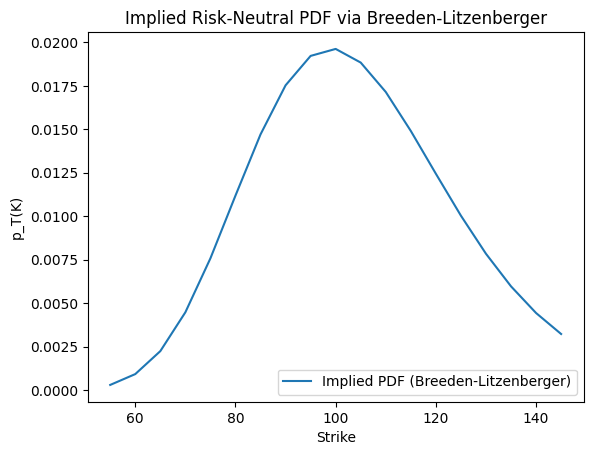

In [2]:
# -----------------------------
# 1. Synthetic Setup
# -----------------------------
r = 0.05      # risk-free rate
T = 1.0       # time to maturity = 1 year
K_min, K_max = 50, 150
num_strikes   = 21
strikes = np.linspace(K_min, K_max, num_strikes)

# Suppose we have a "true" model for call prices just for demonstration
# E.g., from Black-Scholes with some volatility
# We'll pretend these are market prices
S0 = 100      # underlying spot
sigma = 0.20  # volatility

def black_scholes_call_price(S, K, r, T, sigma):
    """
    Black-Scholes formula for a European call option.
    """
    from math import log, sqrt, exp
    from scipy.stats import norm
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call = S * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return call

call_prices = [black_scholes_call_price(S0, K, r, T, sigma) 
               for K in strikes]
call_prices = np.array(call_prices)

# -----------------------------
# 2. Finite Difference (2nd Derivative)
# -----------------------------
pT = []
for i in range(1, num_strikes-1):
    # We do a simple central difference for the second derivative
    K_im1 = strikes[i-1]
    K_i   = strikes[i]
    K_ip1 = strikes[i+1]
    
    C_im1 = call_prices[i-1]
    C_i   = call_prices[i]
    C_ip1 = call_prices[i+1]
    
    # Non-uniform spacing?
    #  - If uniform: DeltaK = K_ip1 - K_i = K_i - K_im1
    #  - We'll assume uniform spacing for simplicity here
    DeltaK = K_ip1 - K_i
    
    second_deriv = (C_ip1 - 2*C_i + C_im1) / (DeltaK**2)
    
    # Apply Breeden-Litzenberger
    pdf_val = np.exp(r*T) * second_deriv
    
    pT.append(pdf_val)

# Strikes at which PDF is computed (missing the first/last)
pT_strikes = strikes[1:-1]
pT = np.array(pT)

# -----------------------------
# 3. Plot Results
# -----------------------------
plt.plot(pT_strikes, pT, label='Implied PDF (Breeden-Litzenberger)')
plt.title("Implied Risk-Neutral PDF via Breeden-Litzenberger")
plt.xlabel("Strike")
plt.ylabel("p_T(K)")
plt.legend()
plt.show()

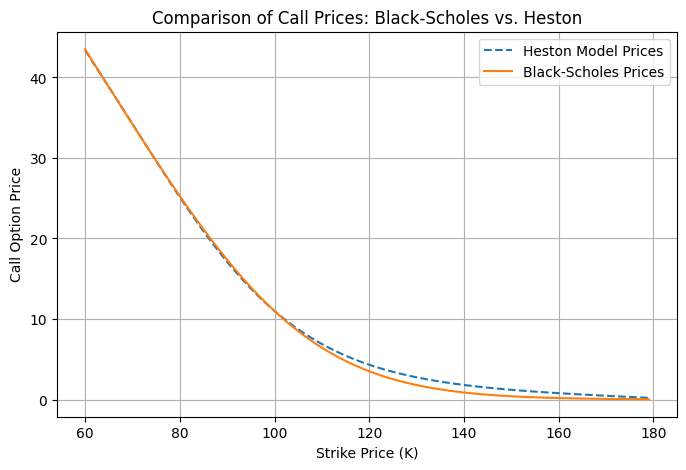

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# -------------------------------------------------
# Black-Scholes Call Price Function
# -------------------------------------------------
def black_scholes_call_price(S, K, r, T, sigma):
    """
    Black-Scholes formula for a European call option.
    """
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    call = S * norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    return call

# -------------------------------------------------
# Heston Model Parameters
# -------------------------------------------------
S0 = 100.0     # Initial stock price
tau = 1.0      # Time to maturity (years)
r = 0.06       # Annual risk-free rate

# Heston-dependent parameters
kappa = 3              # Rate of mean reversion of variance under risk-neutral dynamics
theta = 0.20**2        # Long-term mean of variance under risk-neutral dynamics
v0 = 0.20**2           # Initial variance under risk-neutral dynamics
rho = 0.98            # Correlation between returns and variances
sigma = 0.2           # Volatility of volatility
lambd = 0             # Risk premium of variance

# Ensure the Feller Condition is satisfied
assert 2*kappa*theta > sigma**2, "Feller condition violated!"

# -------------------------------------------------
# Characteristic Function for Heston Model
# -------------------------------------------------
def heston_charfunc(phi, S0, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
    Compute the characteristic function of the Heston model.
    """
    a = kappa * theta
    b = kappa + lambd
    rspi = rho * sigma * phi * 1j
    d = np.sqrt((rspi - b) ** 2 + (phi * 1j + phi ** 2) * sigma ** 2)
    g = (b - rspi + d) / (b - rspi - d)

    exp1 = np.exp(r * phi * 1j * tau)
    term2 = S0 ** (phi * 1j) * ((1 - g * np.exp(d * tau)) / (1 - g)) ** (-2 * a / sigma ** 2)
    exp2 = np.exp(a * tau * (b - rspi + d) / sigma ** 2 + v0 * (b - rspi + d) * 
                 ((1 - np.exp(d * tau)) / (1 - g * np.exp(d * tau))) / sigma ** 2)

    return exp1 * term2 * exp2

# -------------------------------------------------
# Heston Call Price Using Fourier Inversion
# -------------------------------------------------
def heston_price_rec(S0, K, v0, kappa, theta, sigma, rho, lambd, tau, r):
    """
    Compute European call option price using Heston model via Fourier inversion.
    """
    args = (S0, v0, kappa, theta, sigma, rho, lambd, tau, r)

    P, umax, N = 0, 100, 650
    dphi = umax / N  # Step width
    for j in range(1, N):
        phi = dphi * (2 * j + 1) / 2  # Midpoint rule
        numerator = heston_charfunc(phi - 1j, *args) - K * heston_charfunc(phi, *args)
        denominator = 1j * phi * K ** (1j * phi)

        if abs(denominator) > 1e-10:  # Avoid division by zero
            P += dphi * numerator / denominator

    return np.real((S0 - K * np.exp(-r * tau)) / 2 + P / np.pi)

# -------------------------------------------------
# Compute Option Prices for a Range of Strikes
# -------------------------------------------------
strikes = np.arange(60, 180, 1.0)

# Vectorize the function to handle arrays
heston_price_vec = np.vectorize(heston_price_rec)
heston_prices = heston_price_vec(S0, strikes, v0, kappa, theta, sigma, rho, lambd, tau, r)

# Compute Black-Scholes Prices for Comparison
sigma_BS = 0.20
black_scholes_prices = np.array([black_scholes_call_price(S0, K, r, tau, sigma_BS) for K in strikes])

# -------------------------------------------------
# Plot Results
# -------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(strikes, heston_prices, label='Heston Model Prices', linestyle='--')
plt.plot(strikes, black_scholes_prices, label='Black-Scholes Prices', linestyle='-')
plt.xlabel("Strike Price (K)")
plt.ylabel("Call Option Price")
plt.title("Comparison of Call Prices: Black-Scholes vs. Heston")
plt.legend()
plt.grid()
plt.show()

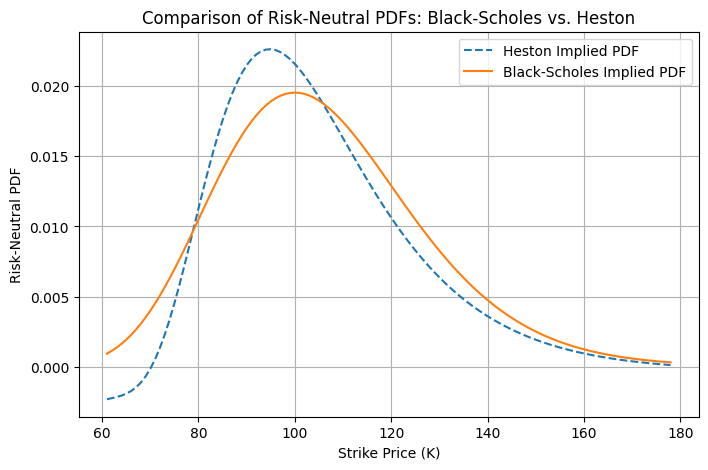

In [4]:
# -------------------------------------------------
# Compute Second Derivative (Risk-Neutral PDF)
# -------------------------------------------------
h = strikes[1] - strikes[0]  # Step size for finite differences

# Create dataframes for second derivatives
heston_df = pd.DataFrame({"strike": strikes, "price": heston_prices})
bs_df = pd.DataFrame({"strike": strikes, "price": black_scholes_prices})

# Second derivative approximation using central finite differences
heston_df['curvature'] = (-2 * heston_df['price'] + heston_df['price'].shift(1) + heston_df['price'].shift(-1)) / h**2
bs_df['curvature'] = (-2 * bs_df['price'] + bs_df['price'].shift(1) + bs_df['price'].shift(-1)) / h**2

# Apply the Breeden-Litzenberger formula
heston_df['risk_neutral_pdf'] = np.exp(r * tau) * heston_df['curvature']
bs_df['risk_neutral_pdf'] = np.exp(r * tau) * bs_df['curvature']

# -------------------------------------------------
# Plot Risk-Neutral PDFs
# -------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(heston_df['strike'], heston_df['risk_neutral_pdf'], label='Heston Implied PDF', linestyle='--')
plt.plot(bs_df['strike'], bs_df['risk_neutral_pdf'], label='Black-Scholes Implied PDF', linestyle='-')
plt.xlabel("Strike Price (K)")
plt.ylabel("Risk-Neutral PDF")
plt.title("Comparison of Risk-Neutral PDFs: Black-Scholes vs. Heston")
plt.legend()
plt.grid()
plt.show()

The Black-Scholes PDF is typically more symmetric and smooth since it assumes a lognormal price distribution.
The Heston PDF often has skewness and a fatter tail due to stochastic volatility effects, better capturing real-world market dynamics.